Project logistics

45 hours my time;
28 hours with software engineer

Until 15 December: Get stuff on github.
Meeting with Jay: Fridays: 2pm-3pm

James is available on Teams; working hours: 9:00-5:00.
TODO: Set up a timeline with goals and achievements each week; get code as soon as possible to gitbug to use branches, pull requests, etc.

What James can help with:
Priority: Working in branches on github:
Pull-Requests on github (Python package index; upload .ipynb to HPC)

2) Modularize the code using classes/OOP/Design Patterns.

3) Writing Unit-Test

4) CI test suits

5) Storage of data (backend)

Use black as a linter and set it up correspondingly in PyCharm.
Should I convert .ipynb files to .py files using a conversion tool?


# Literature 

[1] Scientific Guide To Price Action and Pattern Trading Wisdom of Trend, Cycle, and Fractal Wave (Young Ho Seo)

[2] Finding Alphas: A Quantitative Approach to Building Trading Strategies Hardcover – 27 Sept. 2019 by Igor Tulchinsky (Editor)

[3] 151 Trading Strategies, Z. Kakushadze and J.A. Serur. 151 Trading Strategies. Cham, Switzerland: Palgrave Macmillan, an imprint of Springer Nature, 1st Edition (2018), XX, 480 pp; ISBN 978-3-030-02791-9, https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3247865

# SP500 tickers

In [44]:
# tickers of SP500
# install a linter
# Ticker obtained from public source: https://www.slickcharts.com/sp500; accessed on 4 December 2023
# This ticker list might change in the future. How can I scrape the data automatircally to compare it is still valid?

# Decoding Market Signals: Candlestick patterns

## Third party libraries

In [45]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from IPython.display import Image
import talib

In [46]:
os.getcwd()

'/home/bjs/Desktop/vcs/ReCoDE-DecodingMarketSignals/notebooks'

In [47]:
os.listdir()

['.placeholder', 'ReCoDe_DecodingMarketSignals.ipynb', '.ipynb_checkpoints']

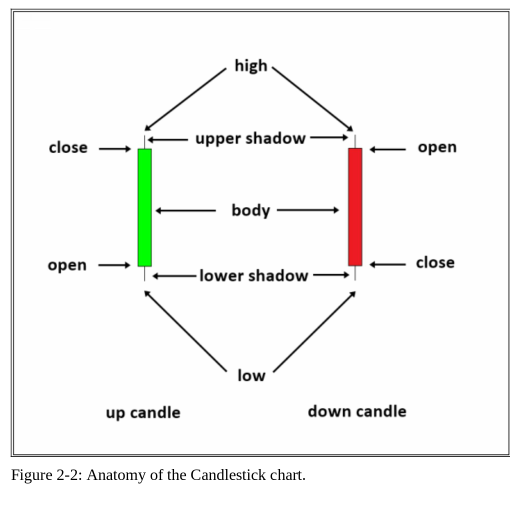

In [48]:
Image(filename='/home/bjs/Desktop/vcs/ReCoDE-DecodingMarketSignals/figures/cs_anatomy.png')

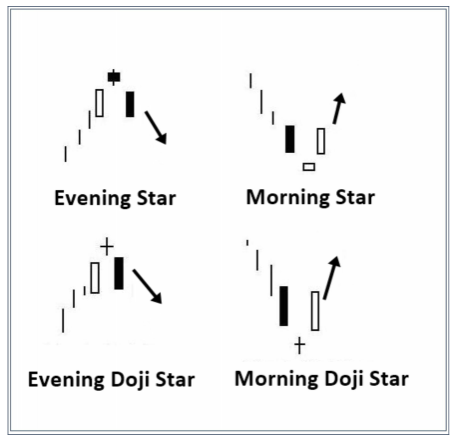

In [49]:
Image(filename='/home/bjs/Desktop/vcs/ReCoDE-DecodingMarketSignals/figures/cs_prediction.png')


![cs_anatomy](/home/bjs/Desktop/vcs/ReCoDE-DecodingMarketSignals/figures/cs_anatomy.png)

![cs_prediction](/home/bjs/Desktop/vcs/ReCoDE-DecodingMarketSignals/figures/cs_prediction.png)

In [50]:
pd.read_csv('./../data/MSFT.csv')

,PERMNO,date,NAMEENDT,SHRCD,EXCHCD,SICCD,NCUSIP,TICKER,COMNAM,SHRCLS,TSYMBOL,NAICS,PRIMEXCH,TRDSTAT,SECSTAT,PERMCO,ISSUNO,HEXCD,HSICCD,CUSIP,DCLRDT,DLAMT,DLPDT,DLSTCD,NEXTDT,PAYDT,RCRDDT,SHRFLG,HSICMG,HSICIG,DISTCD,DIVAMT,FACPR,FACSHR,ACPERM,ACCOMP,SHRENDDT,NWPERM,DLRETX,DLPRC,DLRET,TRTSCD,NMSIND,MMCNT,NSDINX,BIDLO,ASKHI,PRC,VOL,RET,BID,ASK,SHROUT,CFACPR,CFACSHR,OPENPRC,NUMTRD,RETX,vwretd,vwretx,ewretd,ewretx,sprtrn
0,10107,1986-03-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8048,10539,3,7370,59491810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73,737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004543,0.004496,0.005906,0.005866,0.003521
1,10107,1986-03-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8048,10539,3,7370,59491810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73,737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004365,0.003925,0.003272,0.003023,0.004478
2,10107,1986-03-13,2004-06-09,11.0,3.0,7370.0,59491810.0,MSFT,MICROSOFT CORP,NaN,MSFT,NaN,Q,A,R,8048,10539,3,7370,59491810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,73,737,NaN,NaN,NaN,NaN,NaN,NaN,1986-03-30,NaN,NaN,NaN,NaN,1.0,2.0,33.0,2.0,25.50000,29.25000,28.00000,3597701.0,C,27.75000,28.00000,25519.0,288.0,288.0,NaN,3410.0,C,0.002131,0.002104,0.001268,0.001247,0.002795
3,10107,1986-03-14,NaN,11.0,3.0,7370.0,59491810.0,MSFT,MICROSOFT CORP,NaN,MSFT,NaN,Q,A,R,8048,10539,3,7370,59491810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,73,737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,32.0,2.0,28.00000,29.50000,29.00000,1077151.0,0.035714,29.00000,29.25000,25519.0,288.0,288.0,NaN,1809.0,0.035714,0.010278,0.010240,0.005065,0.004965,0.014409
4,10107,1986-03-17,NaN,11.0,3.0,7370.0,59491810.0,MSFT,MICROSOFT CORP,NaN,MSFT,NaN,Q,A,R,8048,10539,3,7370,59491810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,73,737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,27.0,2.0,29.00000,29.75000,29.50000,465719.0,0.017241,29.50000,29.75000,25519.0,288.0,288.0,NaN,772.0,0.017241,-0.007085,-0.007120,-0.004117,-0.004179,-0.007948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9275,10107,2022-12-23,NaN,11.0,3.0,7370.0,59491810.0,MSFT,MICROSOFT CORP,NaN,MSFT,511210.0,Q,A,R,8048,10539,3,7370,59491810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73,737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,233.94279,238.87000,238.73000,21287448.0,0.002267,238.73000,238.77000,7454473.0,1.0,1.0,236.11000,259590.0,0.002267,0.005466,0.005395,0.002459,0.002195,0.005868
9276,10107,2022-12-27,NaN,11.0,3.0,7370.0,59491810.0,MSFT,MICROSOFT CORP,NaN,MSFT,511210.0,Q,A,R,8048,10539,3,7370,59491810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73,737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,235.83000,238.92999,236.96001,16666893.0,-0.007414,236.96001,237.00000,7454473.0,1.0,1.0,238.70000,229209.0,-0.007414,-0.003928,-0.003997,-0.008489,-0.008633,-0.004050
9277,10107,2022-12-28,NaN,11.0,3.0,7370.0,59491810.0,MSFT,MICROSOFT CORP,NaN,MSFT,511210.0,Q,A,R,8048,10539,3,7370,59491810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73,737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,234.17000,239.72000,234.53000,17447853.0,-0.010255,234.49001,234.50000,7454473.0,1.0,1.0,236.89000,217980.0,-0.010255,-0.012366,-0.012383,-0.010297,-0.010560,-0.012021
9278,10107,2022-12-29,NaN,11.0,3.0,7370.0,59491810.0,MSFT,MICROSOFT CORP,NaN,MSFT,511210.0,Q,A,R,8048,10539,3,7370,59491810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73,737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,235.64999,241.92000,241.00999,19727159.0,0.027630,240.96001,241.00999,7454473.0,1.0,1.0,235.64999,227261.0,0.027630,0.018337,0.018135,0.022834,0.022336,0.017461


# Obtaining high-quality price data for stocks

Imperial College offers access to the Wharton Research Data Dervice (WRDS). One can either use the computers in the library or apply for an account. Please see the following link for details:
https://www.imperial.ac.uk/admin-services/library/subject-support/business/wrds/

In case we have login credentials for WRDS, we can submit queries to their data base via
https://wrds-www.wharton.upenn.edu/pages/get-data/center-research-security-prices-crsp/

Now, from within WRDS, we can access stock market data from the Center for Research in Security Analysis (CRSP). WRDS in general and CRSP in particular offer a wide range of financial data, as can be seen from the below figure. For our project, we are explicitely interested in stock market data of S&P 500 components in daily frequency. 

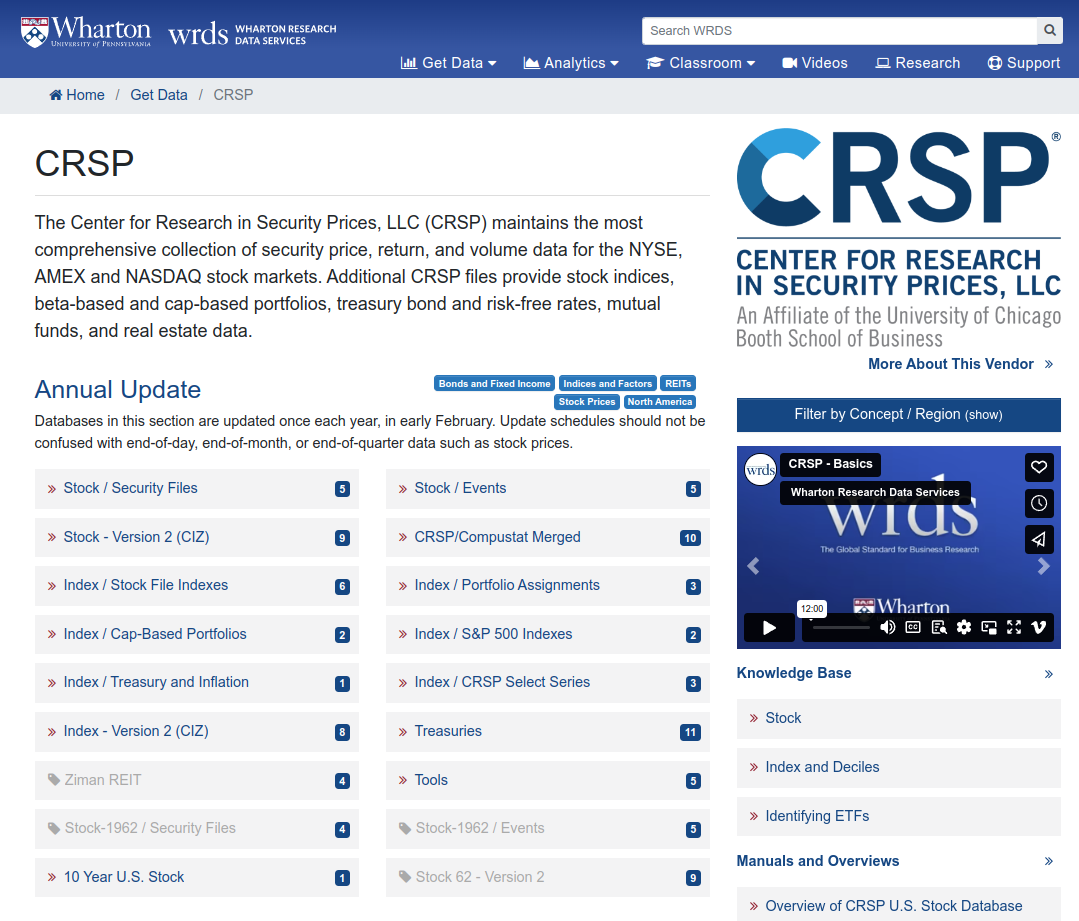

In [51]:
Image(filename='/home/bjs/Desktop/vcs/ReCoDE-DecodingMarketSignals/figures/Wharton_WRDS_CRSP_data.png')

# Loading and pre-processing the data

In [52]:
# what columns are available from the Wharton CRSP data?
pd.read_csv('./../data/MSFT.csv').columns

Index(['PERMNO', 'date', 'NAMEENDT', 'SHRCD', 'EXCHCD', 'SICCD', 'NCUSIP',
       'TICKER', 'COMNAM', 'SHRCLS', 'TSYMBOL', 'NAICS', 'PRIMEXCH', 'TRDSTAT',
       'SECSTAT', 'PERMCO', 'ISSUNO', 'HEXCD', 'HSICCD', 'CUSIP', 'DCLRDT',
       'DLAMT', 'DLPDT', 'DLSTCD', 'NEXTDT', 'PAYDT', 'RCRDDT', 'SHRFLG',
       'HSICMG', 'HSICIG', 'DISTCD', 'DIVAMT', 'FACPR', 'FACSHR', 'ACPERM',
       'ACCOMP', 'SHRENDDT', 'NWPERM', 'DLRETX', 'DLPRC', 'DLRET', 'TRTSCD',
       'NMSIND', 'MMCNT', 'NSDINX', 'BIDLO', 'ASKHI', 'PRC', 'VOL', 'RET',
       'BID', 'ASK', 'SHROUT', 'CFACPR', 'CFACSHR', 'OPENPRC', 'NUMTRD',
       'RETX', 'vwretd', 'vwretx', 'ewretd', 'ewretx', 'sprtrn'],
      dtype='object')

We can make use of a technique called `method chaining` to pipe multiple processing steps within Pandas. This offers two advantages
 - We start from the raw data as input statement initially. In case the data is small enough to be processed in-memory, we do not require to store intermediary results on disk which confuses transparency and is less efficient.
 - Increased code readability and transparency for debugging.

In [53]:
df = (
    pd.read_csv('./../data/MSFT.csv', usecols=['date', 'OPENPRC', 'ASKHI', 'BIDLO', 'PRC', 'VOL'])
    .rename(columns={'OPENPRC': 'open', 'ASKHI': 'high', 'BIDLO': 'low', 'PRC': 'close', 'VOL':'vol'})
    .dropna()
    .reset_index()
    .assign(date=lambda df: pd.to_datetime(df['date'], format='%Y-%m-%d'),
            vol=lambda df: df['vol'].astype(int),
            intraday_return=lambda df: (df['close'] - df['open']) / df['open'],
            sign_intraday_return=lambda df: np.sign(df['intraday_return']).astype(int))
    [['date', 'open', 'high', 'low', 'close', 'vol', 'intraday_return', 'sign_intraday_return']]
#     .set_index('date')
)

df

,date,open,high,low,close,vol,intraday_return,sign_intraday_return
0,1992-06-15,75.00000,78.00000,75.00000,75.75000,1707931,0.010000,1
1,1992-06-16,75.50000,76.50000,72.50000,72.75000,1800280,-0.036424,-1
2,1992-06-17,72.50000,73.25000,71.50000,72.37500,2196679,-0.001724,-1
3,1992-06-18,73.00000,74.75000,71.00000,72.25000,1706769,-0.010274,-1
4,1992-06-19,73.50000,74.25000,72.75000,73.50000,1350828,0.000000,0
...,...,...,...,...,...,...,...,...
7685,2022-12-23,236.11000,238.87000,233.94279,238.73000,21287448,0.011097,1
7686,2022-12-27,238.70000,238.92999,235.83000,236.96001,16666893,-0.007289,-1
7687,2022-12-28,236.89000,239.72000,234.17000,234.53000,17447853,-0.009962,-1
7688,2022-12-29,235.64999,241.92000,235.64999,241.00999,19727159,0.022746,1


In [54]:
df['previous_day_return'] = df['sign_intraday_return'].shift(+1)#.dropna().astype(int)
df['log_return'] = np.log(df['close'] / df['close'].shift(-1))
df['5_days_mean_return'] = df['log_return'].rolling(window=5, min_periods=1).mean().shift(-5)  # Idea: Compute 5 days average ahead returns one day after the signal. using pd.rolling and pd.shift.
df = df.dropna()
# df['previous_day_return'] = df['previous_day_return'].astype(int)
df.reset_index(drop=True, inplace=True)  

In [55]:
df.head()

,date,open,high,low,close,vol,intraday_return,sign_intraday_return,previous_day_return,log_return,5_days_mean_return
0,1992-06-16,75.50,76.50,72.50,72.750,1800280,-0.036424,-1,1.0,0.005168,0.000346
1,1992-06-17,72.50,73.25,71.50,72.375,2196679,-0.001724,-1,-1.0,0.001729,0.006327
2,1992-06-18,73.00,74.75,71.00,72.250,1706769,-0.010274,-1,-1.0,-0.017153,0.019266
3,1992-06-19,73.50,74.25,72.75,73.500,1350828,0.000000,0,-1.0,-0.010152,0.005461
4,1992-06-22,73.25,74.50,71.50,74.250,1709631,0.013652,1,0.0,0.010152,0.009758


# What candlestick patterns are available?

In [56]:
candle_names = talib.get_function_groups()['Pattern Recognition']
list_of_results_df = []
# for ListingId in df['ListingId'].unique():
#     equity_df = df.loc[df['ListingId']==ListingId].reset_index()
    
for signal in candle_names:
    tds = df.copy()
    tds['cs_pattern'] = getattr(talib, signal)(df['open'], df['high'], df['low'], df['close'])
    tds['signal'] = signal
    list_of_results_df.append(tds.set_index(['signal','date']))
        
result_df = pd.concat(list_of_results_df)

In [57]:
result_df

open       high        low      close  \
signal              date                                                     
CDL2CROWS           1992-06-16   75.50000   76.50000   72.50000   72.75000   
                    1992-06-17   72.50000   73.25000   71.50000   72.37500   
                    1992-06-18   73.00000   74.75000   71.00000   72.25000   
                    1992-06-19   73.50000   74.25000   72.75000   73.50000   
                    1992-06-22   73.25000   74.50000   71.50000   74.25000   
...                                   ...        ...        ...        ...   
CDLXSIDEGAP3METHODS 2022-12-16  248.55000  249.84000  243.50999  244.69000   
                    2022-12-19  244.86000  245.21001  238.71001  240.45000   
                    2022-12-20  239.39999  242.91000  238.42000  241.80000   
                    2022-12-21  241.69000  245.61501  240.11000  244.42999   
                    2022-12-22  241.25500  241.99001  233.87000  238.19000   

                                     vol  intraday_return  \
signal              date                                    
CDL2CROWS           1992-06-16   1800280        -0.036424   
                    1992-06-17   2196679        -0.001724   
                    1992-06-18   1706769        -0.010274   
                    1992-06-19   1350828         0.000000   
                    1992-06-22   1709631         0.013652   
...                                  ...              ...   
CDLXSIDEGAP3METHODS 2022-12-16  94651273        -0.015530   
                    2022-12-19  29634558        -0.018010   
                    2022-12-20  25126887         0.010025   
                    2022-12-21  23639790         0.011337   
                    2022-12-22  28616381        -0.012704   

                                sign_intraday_return  previous_day_return  \
signal              date                                                    
CDL2CROWS           1992-06-16                    -1                  1.0   
                    1992-06-17                    -1                 -1.0   
                    1992-06-18                    -1                 -1.0   
                    1992-06-19                     0                 -1.0   
                    1992-06-22                     1                  0.0   
...                                              ...                  ...   
CDLXSIDEGAP3METHODS 2022-12-16                    -1                 -1.0   
                    2022-12-19                    -1                 -1.0   
                    2022-12-20                     1                 -1.0   
                    2022-12-21                     1                  1.0   
                    2022-12-22                    -1                  1.0   

                                log_return  5_days_mean_return  cs_pattern  
signal              date                                                    
CDL2CROWS           1992-06-16    0.005168            0.000346           0  
                    1992-06-17    0.001729            0.006327           0  
                    1992-06-18   -0.017153            0.019266           0  
                    1992-06-19   -0.010152            0.005461           0  
                    1992-06-22    0.010152            0.009758           0  
...                                    ...                 ...         ...  
CDLXSIDEGAP3METHODS 2022-12-16    0.017480            0.002924           0  
                    2022-12-19   -0.005599            0.006105           0  
                    2022-12-20   -0.010818            0.002818           0  
                    2022-12-21    0.025860           -0.001364           0  
                    2022-12-22   -0.002265           -0.001139           0  

[468724 rows x 11 columns]

## How to visually inspect the signals?

In [58]:
import plotly.graph_objects as go

def plot_cs_chart(df: pd.DataFrame, ListingId=None) -> go.Figure:
    if ListingId is None:
        fig = go.Figure(data=[go.Candlestick(x=df.index,
                    open=df['open'],
                    high=df['high'],
                    low=df['low'],
                    close=df['close']
                    )])

        fig.update_layout(
            font=dict(size=18),
            legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.99,font=dict(size= 20)),
            title = 'Evolution of price chart diplayed as candlestick chart',
            xaxis_title='time [days]',
            yaxis_title="price",
            autosize=False,
            width=800,
            height=800
            )

        fig.show()
    
    elif ListingId is not None:
        fig = go.Figure(data=[go.Candlestick(x=df['Date'][df['ListingId']==ListingId],
                        open=df['open'][df['ListingId']==ListingId],
                        high=df['high'][df['ListingId']==ListingId],
                        low=df['low'][df['ListingId']==ListingId],
                        close=df['close'][df['ListingId']==ListingId]
                        )])

        fig.update_layout(
            font=dict(size=18),
            legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.99,font=dict(size= 20)),
            title = 'Evolution of price chart diplayed as candlestick chart',
            xaxis_title='time [days]',
            yaxis_title="price",
            autosize=False,
            width=800,
            height=800
            )

        fig.show()
        
    else:
        print('Do not understand plotting instruction. Check data frame and ListingId')

In [59]:
plot_cs_chart(result_df.loc['CDLDOJI'].reset_index().set_index('date')[:20])

#TODO: Implement performance metric
TP  FP
FN  TN

TPR = TP / (TP+TN) 

Accuracy = ... > 50%
Precision = ...

for example using:
```
doji_df = result_df.loc['CDLDOJI']
doji_df.head()

# conditions for classical doji
doji_df['TruePositive'] = np.where((doji_df['cs_pattern']>0) & (doji_df['previous_day_return']>0) & (doji_df['close'].shift(+1)<(doji_df['close'])) & (doji_df['NextDayOpen']<doji_df['Close|Executed']) & (doji_df['NextDayReturn']<0), 1,
                            np.where((doji_df['cs_pattern']>0) & (doji_df['previous_day_return']<0) & (doji_df['close'].shift(+1)>(doji_df['close'])) &(doji_df['NextDayOpen']>doji_df['Close|Executed']) & (doji_df['NextDayReturn']>0), 1,
                            0))

doji_df['FalsePositive'] = np.where((doji_df['cs_pattern']>0) & (doji_df['previous_day_return']>0) & (doji_df['close'].shift(+1)<(doji_df['close'])) & (doji_df['NextDayOpen']<doji_df['Close|Executed']) & (doji_df['NextDayReturn']>0), 1,
                            np.where((doji_df['cs_pattern']>0) & (doji_df['previous_day_return']<0) & (doji_df['close'].shift(+1)>(doji_df['close'])) &(doji_df['NextDayOpen']>doji_df['Close|Executed']) & (doji_df['NextDayReturn']<0), 1,
                            0))

doji_df['TruePositive5'] = np.where((doji_df['cs_pattern']>0) & (doji_df['previous_day_return']>0) & (doji_df['close'].shift(+1)<(doji_df['close'])) & (doji_df['NextDayOpen']<doji_df['Close|Executed']) & (doji_df['5DaysMeanReturn']<0), 1,
                            np.where((doji_df['cs_pattern']>0) & (doji_df['previous_day_return']<0) & (doji_df['close'].shift(+1)>(doji_df['close'])) &(doji_df['NextDayOpen']>doji_df['Close|Executed']) & (doji_df['5DaysMeanReturn']>0), 1,
                            0))

doji_df['FalsePositive5'] = np.where((doji_df['cs_pattern']>0) & (doji_df['previous_day_return']>0) & (doji_df['close'].shift(+1)<(doji_df['close'])) & (doji_df['NextDayOpen']<doji_df['Close|Executed']) & (doji_df['5DaysMeanReturn']>0), 1,
                            np.where((doji_df['cs_pattern']>0) & (doji_df['previous_day_return']<0) & (doji_df['close'].shift(+1)>(doji_df['close'])) &(doji_df['NextDayOpen']>doji_df['Close|Executed']) & (doji_df['5DaysMeanReturn']<0), 1,
                            0))

doji_df['Signal'] = 'doji'
```

# TODO:Account curve
compare account curve to a benchmark
cumprod(predictio_t * return_t )
benchmark: SP500

# Appendix

```
import talib

def compute_intraday_return(row):
    row['positive_intraday'] = np.where((row['Close|Executed'] - row['Open|Executed']) > 0, True, False)
    return row

cs_performance_dict = dict()

for ListingId in df['ListingId'].unique():
    equity_df = pd.DataFrame(index=df[df['ListingId']==ListingId]['Date'], 
                                data=df[df['ListingId']==ListingId][['Open|Executed', 'High|Executed', 'Low|Executed', 'Close|Executed']].values, 
                                columns = df[df['ListingId']==ListingId][['Open|Executed', 'High|Executed', 'Low|Executed', 'Close|Executed']].columns
                            )
    equity_df = equity_df.apply(compute_intraday_return, axis='columns')
    
    results = []
    cols = []
    for attr in dir(talib):
        if attr[:3]=='CDL':
            res = getattr(talib, attr)(equity_df['Open|Executed'], equity_df['High|Executed'], equity_df['Low|Executed'], equity_df['Close|Executed'])
            results.append(res)
            cols.append(attr)

    patterns = pd.DataFrame(results).T
    patterns.columns = cols
    
    signal_df = patterns[(patterns.select_dtypes(include=['number']) != 0).any(1)]  # alternative: patterns.loc[(patterns.loc[:, patterns.dtypes != object] != 0).any(1)]
    
    signal_and_return_df = signal_df.sum(axis=1).rename('cumulative_signal').to_frame().merge(equity_df['positive_intraday'].shift(-1), left_index=True, right_index=True)[:-1]  # dont count the last as its return will be NaN
    signal_and_return_df = signal_and_return_df.loc[signal_and_return_df['cumulative_signal'] != 0]
    signal_and_return_df['performance'] = np.where((signal_and_return_df['cumulative_signal']>0) & (signal_and_return_df['positive_intraday']==True), True,
                                                   np.where((signal_and_return_df['cumulative_signal']<0) & (signal_and_return_df['positive_intraday']==False), True, False))
    
    TP = signal_and_return_df['performance'].sum() / (signal_and_return_df['performance'].shape[0] & Where the signaal occurs )  #TODO modify the ratio of TP/FP
    FP = 1-TP                                                                                      # 
    
    cs_performance_dict[ListingId] = {'TP_rate':round(TP, 4), 'FP_rate':round(FP, 4)}
```